In [1]:
import os
import sv as SV
import numpy as np
import pylab as pl
import astropy.table as atable
from tqdm.notebook import tqdm, trange

from desiutil.dust import mwdust_transmission, ext_odonnell
from desitarget.sv1.sv1_targetmask import bgs_mask as sv1_bgs_mask
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask
from desispec.tsnr import tsnr2_to_efftime

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
# load compiled zsuccess rates to file
#dat_dir = '/global/cscratch1/sd/chahah/bgs-cmxsv/sv-paper/'
dat_dir = '/global/cscratch1/sd/mjwilson/desi/BGS/bgs-cmxsv/'

sv1_gals = atable.Table.read(os.path.join(dat_dir, 'sv1.bgs_exps.efftime160_200.zsuccess.v3.fits'))
sv3_gals = atable.Table.read(os.path.join(dat_dir, 'sv3.bgs_exps.efftime160_200.zsuccess.v3.fits'))
main_gals = atable.Table.read(os.path.join(dat_dir, 'main.bgs_exps.efftime160_200.zsuccess.v3.fits'))

(0.0, 20.0)

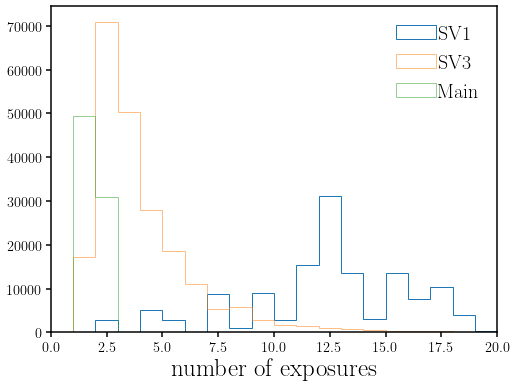

In [4]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

_ = sub.hist(sv1_gals['DEEP_NUMEXP'], range=(0., 20), bins=20, label='SV1', histtype='step')
_ = sub.hist(sv3_gals['DEEP_NUMEXP'], range=(0., 20), bins=20, alpha=0.5, label='SV3', histtype='step')
_ = sub.hist(main_gals['DEEP_NUMEXP'], range=(0., 20), bins=20, alpha=0.5, label='Main', histtype='step')

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)

sub.set_xlabel('number of exposures', fontsize=25)

sub.set_xlim(0., 20)

## Calculate MW transmission

In [5]:
sv1_gals = sv1_gals[(sv1_gals['PHOTSYS'] != '') & (sv1_gals['PHOTSYS'] != 'G')]
sv3_gals = sv3_gals[ sv3_gals['PHOTSYS'] != '']

In [6]:
from speclite import filters

decamwise    = filters.load_filters('decam2014-g', 'decam2014-r','decam2014-z', 'wise2010-W1', 'wise2010-W2')
bassmzlswise = filters.load_filters('BASS-g', 'BASS-r', 'MzLS-z','wise2010-W1', 'wise2010-W2')

In [7]:
bassmzlswise.effective_wavelengths.value

array([ 4815.95363513,  6437.79282937,  9229.65786449, 34002.54044482,
       46520.07577119])

In [8]:
decamwise.effective_wavelengths.value

array([ 4890.03670428,  6469.62203811,  9196.46396394, 34002.54044482,
       46520.07577119])

In [9]:
RV = 3.1

In [10]:
_sv1_mw_trans = np.array([     10**(-0.4 * sv1_gals['EBV'][i] * RV * ext_odonnell(bassmzlswise.effective_wavelengths.value, Rv=RV)) if sv1_gals['PHOTSYS'][i] == 'N'
                         else 10**(-0.4 * sv1_gals['EBV'][i] * RV * ext_odonnell(   decamwise.effective_wavelengths.value, Rv=RV)) for i in range(len(sv1_gals['EBV']))])

In [11]:
RV * ext_odonnell(bassmzlswise.effective_wavelengths.value, Rv=RV)

array([3.70725607, 2.57175885, 1.42493233, 0.17458614, 0.10540034])

In [12]:
RV * ext_odonnell(decamwise.effective_wavelengths.value, Rv=RV)

array([3.63476336, 2.55808601, 1.43322196, 0.17458614, 0.10540034])

In [13]:
np.unique(sv1_gals['PHOTSYS'].data.astype(np.str))

array(['N', 'S'], dtype='<U1')

In [14]:
mwdust_transmission?

Signature: mwdust_transmission(ebv, band, photsys, match_legacy_surveys=False)
Docstring:
Convert SFD E(B-V) value to dust transmission 0-1 for band and photsys

Args:
    ebv (float or array-like): SFD E(B-V) value(s)
    band (str): 'G', 'R', or 'Z'
    photsys (str or array of str): 'N' or 'S' imaging surveys photo system

Returns:
    scalar or array (same as ebv input), Milky Way dust transmission 0-1

If `photsys` is an array, `ebv` must also be array of same length.
However, `ebv` can be an array with a str `photsys`.

Also see `dust_transmission` which returns transmission vs input wavelength
File:      /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desiutil/3.2.2/lib/python3.8/site-packages/desiutil/dust.py
Type:      function


In [15]:
sv1_mw_trans = [mwdust_transmission(sv1_gals['EBV'].data, band, sv1_gals['PHOTSYS'].data.astype(str), match_legacy_surveys=False) for band in ['g', 'r', 'z']]
sv1_mw_trans = np.vstack(sv1_mw_trans).T
sv1_mw_trans.shape

(126027, 3)

In [16]:
# ngal x n band. 
_sv1_mw_trans.shape, sv1_mw_trans.shape

((126027, 5), (126027, 3))

(0.25, 1.1)

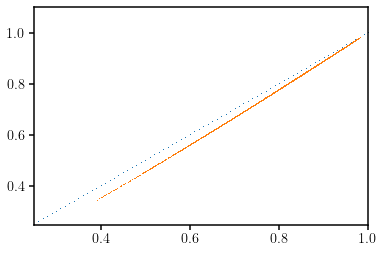

In [17]:
xs = np.arange(0.0, 1.5, 0.01)

pl.plot(xs, xs, marker=',', lw=0.0, label='y=x')
pl.plot(sv1_mw_trans[:,0], _sv1_mw_trans[:,0], marker=',', lw=0.0)

pl.xlim(0.25, 1.0)
pl.ylim(0.25, 1.1)

In [18]:
_sv3_mw_trans = np.array([10**(-0.4 * sv3_gals['EBV'][i] * RV * ext_odonnell(bassmzlswise.effective_wavelengths.value, Rv=RV)) if sv3_gals['PHOTSYS'][i] == 'N'
                         else 10**(-0.4 * sv3_gals['EBV'][i] * RV * ext_odonnell(decamwise.effective_wavelengths.value, Rv=RV)) for i in range(len(sv3_gals['EBV']))])

In [19]:
sv3_mw_trans = [mwdust_transmission(sv3_gals['EBV'].data, band, sv3_gals['PHOTSYS'].data.astype(str), match_legacy_surveys=False) for band in ['g', 'r', 'z']]
sv3_mw_trans = np.vstack(sv3_mw_trans).T
sv3_mw_trans.shape

(204709, 3)

In [20]:
sv3_gals['EBV'].data.shape

(204709,)

In [21]:
sv1_deep = (sv1_gals['DEEP_EXPTIME'] > 2000) & (tsnr2_to_efftime(sv1_gals['TSNR2_BGS'].data, 'bgs') > 180.)

sv3_deep = (tsnr2_to_efftime(sv3_gals['TSNR2_BGS'].data, 'bgs') > 180.)

# Bad idea: (sv3_gals['DEEP_NUMEXP'] > 2) - accidentally prefers those with repeated redshifts. 

np.mean(sv1_deep), np.mean(sv3_deep)

INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.16.0/data/tsnr/tsnr-ensemble-gpbdark.fits apply scale factor = 1.000
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.16.0/data/tsnr/tsnr-ensemble-elg.fits apply scale factor = 1.261
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.16.0/data/tsnr/tsnr-ensemble-gpbbright.fits apply scale factor = 1.000
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.16.0/data/tsnr/tsnr-ensemble-lya.fits apply scale factor = 0.998
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.16.0/data/tsnr/tsnr-ensemble-bgs.fits apply scale factor = 2.652
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/202008

(0.33901465558967525, 0.5944242803198687)

In [22]:
ps, cs = np.unique(sv3_gals['PRIORITY'].data[sv3_deep], return_counts=True)

for p, c in zip(ps, cs):
    print('{:d}\t{:d}'.format(p, c))

2	48218
90	5
82000	132
82100	378
92000	424
92100	716
101400	10
101500	54
102000	27805
102100	43939
102998	3


In [23]:
sv3_deep &= np.isin(sv3_gals['PRIORITY'].data, np.array([102100, 102000])) 

In [24]:
ps, cs = np.unique(sv3_gals['PRIORITY'].data[sv3_deep], return_counts=True)

for p, c in zip(ps, cs):
    print('{:d}\t{:d}'.format(p, c))

102000	27805
102100	43939


In [25]:
sv1_gmag = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_G']/sv1_mw_trans[:,0]).clip(1e-16))
sv1_rmag = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_R']/sv1_mw_trans[:,1]).clip(1e-16))
sv1_zmag = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_Z']/sv1_mw_trans[:,2]).clip(1e-16))
sv1_rfib = 22.5 - 2.5 * np.log10((sv1_gals['FIBERFLUX_R']/sv1_mw_trans[:,1]).clip(1e-16))

# sv1_w1 = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_W1']/sv1_mw_trans[:,3]).clip(1e-16))

sv1_brgt = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_BRIGHT']) != 0 
sv1_lowq = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_LOWQ']) != 0 
sv1_fain = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_FAINT']) != 0

sv3_gmag = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_G']/sv3_mw_trans[:,0]).clip(1e-16))
sv3_rmag = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_R']/sv3_mw_trans[:,1]).clip(1e-16))
sv3_zmag = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_Z']/sv3_mw_trans[:,2]).clip(1e-16))
sv3_rfib = 22.5 - 2.5 * np.log10((sv3_gals['FIBERFLUX_R']/sv3_mw_trans[:,1]).clip(1e-16))

# sv3_w1   = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_W1']/sv3_mw_trans[:,3]).clip(1e-16))

sv3_brgt = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT']) != 0 
sv3_fain = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_FAINT']) != 0 

[1.         1.         1.         0.97674419 1.         0.99122807
 0.99240506 0.99614396 0.99568345 0.98628429 0.98592965 0.97036287
 0.93741799 0.83916925]


(0.6, 1.08)

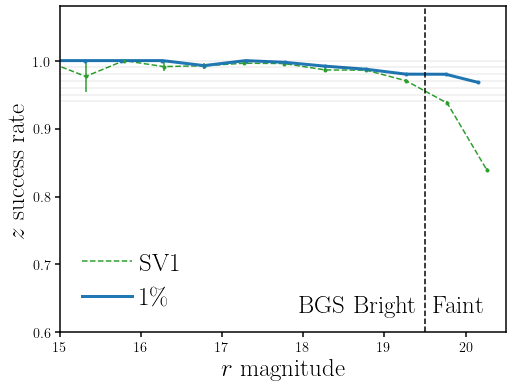

In [29]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

rmid, zsrate, err_zsrate = SV.zsuccess_rate(sv1_rmag[sv1_deep & ~sv1_lowq], sv1_gals['ZSUCCESS'][sv1_deep & ~sv1_lowq], range=(12, 22), nbins=20)
sub.errorbar(rmid, zsrate, yerr=err_zsrate, fmt='.C2')
print(zsrate)
sub.plot(rmid, zsrate, c='C2', ls='--', label='SV1')

rmid, zsrate, err_zsrate = SV.zsuccess_rate(sv3_rmag[sv3_deep], sv3_gals['ZSUCCESS'][sv3_deep], range=(12, 22), nbins=20)
sub.errorbar(rmid, zsrate, yerr=err_zsrate, fmt='.C0')
sub.plot(rmid, zsrate, c='C0', lw=3, label='$1\%$')


for hh in np.arange(1., 0.94, -0.01):
    sub.axhline(hh, color='k', linestyle='-', lw=0.1)

sub.axvline(19.5, color='k', linestyle='--')
sub.text(19.4, 0.63, 'BGS Bright', ha='right', fontsize=25, rotation=0)
sub.text(19.6, 0.63, 'Faint', ha='left', fontsize=25, rotation=0)

sub.legend(loc='lower left', fontsize=25, handletextpad=0.3)
sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 20.5)
sub.set_ylabel('$z$ success rate', fontsize=25)
sub.set_ylim(0.6, 1.08)

In [17]:
sv1_fibcol = (sv1_zmag - sv1_w1) - 3/2.5 * (sv1_gmag - sv1_rmag) + 1.2
sv3_fibcol = (sv3_zmag - sv3_w1) - 3/2.5 * (sv3_gmag - sv3_rmag) + 1.2

# Done.